In [1]:
from rdkit import Chem
import py3Dmol
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True

In [2]:
def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    # viewer.addPropertyLabels("atom","","")

    # for i, at in enumerate(mol):
    #     default = {"stick": {'color': 'black'}}
    #     viewer.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", default))

    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

In [3]:
def get_torsions(mol_list):
    atom_counter = 0
    torsionList = []
    dihedralList = []
    for m in mol_list:
        torsionSmarts = '[!$(*#*)&!D1]-&!@[!$(*#*)&!D1]'
        torsionQuery = Chem.MolFromSmarts(torsionSmarts)
        matches = m.GetSubstructMatches(torsionQuery)
        conf = m.GetConformer()
        for match in matches:
            idx2 = match[0]
            idx3 = match[1]
            bond = m.GetBondBetweenAtoms(idx2, idx3)
            jAtom = m.GetAtomWithIdx(idx2)
            kAtom = m.GetAtomWithIdx(idx3)
            for b1 in jAtom.GetBonds():
                if (b1.GetIdx() == bond.GetIdx()):
                    continue
                idx1 = b1.GetOtherAtomIdx(idx2)
                for b2 in kAtom.GetBonds():
                    if ((b2.GetIdx() == bond.GetIdx())
                            or (b2.GetIdx() == b1.GetIdx())):
                        continue
                    idx4 = b2.GetOtherAtomIdx(idx3)
                    # skip 3-membered rings
                    if (idx4 == idx1):
                        continue
                    # skip torsions that include hydrogens
                    #                     if ((m.GetAtomWithIdx(idx1).GetAtomicNum() == 1)
                    #                         or (m.GetAtomWithIdx(idx4).GetAtomicNum() == 1)):
                    #                         continue
                    if m.GetAtomWithIdx(idx4).IsInRing():
                        torsionList.append(
                            (idx4 + atom_counter, idx3 + atom_counter, idx2 + atom_counter, idx1 + atom_counter))
                        break
                    else:
                        torsionList.append(
                            (idx1 + atom_counter, idx2 + atom_counter, idx3 + atom_counter, idx4 + atom_counter))
                        break
                break

        atom_counter += m.GetNumAtoms()
    return torsionList


In [5]:
mol = Chem.SDMolSupplier('/share/project/sharefs-skfeng/xyz2mol/asp_test.sdf')[0]
import pickle
# with open('test_mol.pkl', 'rb') as handle:
#     mol = pickle.load(handle)
viewer = MolTo3DView(mol, size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [6]:
noh_mol = Chem.RemoveHs(mol)
rotable_bonds = get_torsions([noh_mol])
print(rotable_bonds)
print(mol.GetNumAtoms())


[(0, 5, 10, 7), (1, 6, 12, 11), (6, 12, 11, 4)]
13


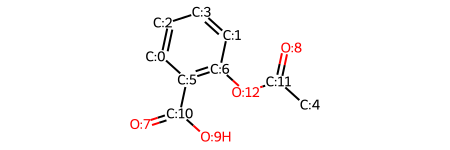

In [7]:
def show_atom_number(mol, label):
    # mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetProp(label, str(i))
    mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    return mol
show_atom_number(mol, 'molAtomMapNumber')

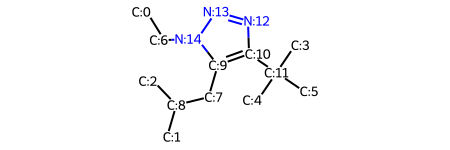

In [28]:
show_atom_number(noh_mol, 'molAtomMapNumber')

In [10]:
from rdkit.Chem import rdMolTransforms
import copy

def SetDihedral(conf, atom_idx, new_vale):
    rdMolTransforms.SetDihedralDeg(conf, atom_idx[0], atom_idx[1], atom_idx[2], atom_idx[3], new_vale)


def GetDihedral(conf, atom_idx):
    return rdMolTransforms.GetDihedralDeg(conf, atom_idx[0], atom_idx[1], atom_idx[2], atom_idx[3])

def apply_changes(mol, values, rotable_bonds):
    opt_mol = copy.deepcopy(mol)
    #     opt_mol = add_rdkit_conformer(opt_mol)

    # apply rotations
    [SetDihedral(opt_mol.GetConformer(), rotable_bonds[r], values[r]) for r in range(len(rotable_bonds))]

    #     # apply transformation matrix
    #     rdMolTransforms.TransformConformer(opt_mol.GetConformer(), GetTransformationMatrix(values[:6]))

    return opt_mol

In [11]:
org_angle = []
for rot_bond in rotable_bonds:
    org_angle.append(GetDihedral(mol.GetConformer(), rot_bond))
print(org_angle)
import numpy as np
org_angle = np.array(org_angle)

[-177.9487339347172, -5.151855576999505, 84.49682673955705, 3.2607790675568937]


In [12]:
opt_mol = copy.deepcopy(mol)
SetDihedral(opt_mol.GetConformer(), (14, 9, 7, 0), 60)
coords2 = opt_mol.GetConformer().GetPositions()
print(coords2)

ValueError: atoms j and k must be bonded

In [13]:
coords2 = mol.GetConformer().GetPositions()
print(coords2)

[[ 1.306  -3.0661  0.2768]
 [ 2.41   -2.3947 -0.5528]
 [ 0.3649  1.4531 -1.0923]
 [-0.1949 -2.1376 -2.789 ]
 [-0.4855  2.7069 -0.8899]
 [ 0.4899 -1.8792  0.8071]
 [-0.4651 -2.3871 -4.1049]
 [ 1.7574 -1.3439 -3.7638]
 [ 1.0919 -1.538  -2.5802]
 [ 1.6906 -1.1959 -1.2256]
 [ 0.0547  0.373  -0.062 ]
 [-0.1768  3.6888 -1.9391]
 [ 0.6853 -0.8347 -0.2112]
 [-0.7221  0.5604  0.8728]
 [ 0.8428 -1.8927 -5.1306]]


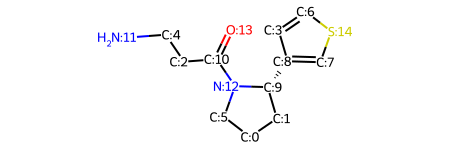

In [14]:
def show_atom_number(mol, label):
    # mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetProp(label, str(i))
    mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    return mol
show_atom_number(mol, 'molAtomMapNumber')

In [15]:
bond_set = []
for bond in mol.GetBonds():
    a1 = bond.GetBeginAtom().GetIdx()
    a2 = bond.GetEndAtom().GetIdx()
    bond_set.append([a1, a2])
print(bond_set)

[[0, 5], [1, 0], [2, 4], [2, 10], [3, 8], [6, 3], [7, 8], [9, 8], [9, 1], [9, 12], [10, 13], [11, 4], [12, 10], [12, 5], [14, 6], [14, 7]]


In [16]:
# init cut bond
print(rotable_bonds)

[(10, 2, 4, 11), (4, 2, 10, 13), (1, 9, 8, 3), (9, 12, 10, 2)]


In [17]:
cut_bonds_set = []
for rb in rotable_bonds:
    cut_bonds_set.append([rb[1], rb[2]])
print(cut_bonds_set)

[[2, 4], [2, 10], [9, 8], [12, 10]]


In [18]:
# frag the graph
left_bond_set = []
    
for ele in bond_set:
    if [ele[0], ele[1]] not in cut_bonds_set and \
        [ele[1], ele[0]] not in cut_bonds_set:
            left_bond_set.append(ele)
print(left_bond_set)     

[[0, 5], [1, 0], [3, 8], [6, 3], [7, 8], [9, 1], [9, 12], [10, 13], [11, 4], [12, 5], [14, 6], [14, 7]]


In [19]:
from collections import defaultdict
graph = defaultdict(list)

for x, y in left_bond_set:
    graph[x].append(y)
    graph[y].append(x)

visited = set()
mol_num = mol.GetNumAtoms()
labels = [-1 for _ in range(mol_num)]

rg_nodes = defaultdict(set) # key is the node idx of rigid-node graph, value is the indices of corresponding node in original mol graph.

def dfs(i, lb=-1):
    visited.add(i)
    labels[i] = lb
    rg_nodes[lb].add(i)
    for j in graph[i]:
        if j not in visited:
            dfs(j, lb)

lb = 0
for i in range(mol_num):
    if i not in visited:
        dfs(i, lb)
        lb += 1
print(labels)
print(rg_nodes)

[0, 0, 1, 2, 3, 0, 2, 2, 2, 0, 4, 3, 0, 4, 2]
defaultdict(<class 'set'>, {0: {0, 1, 5, 9, 12}, 1: {2}, 2: {3, 6, 7, 8, 14}, 3: {11, 4}, 4: {10, 13}})


In [20]:
# construct rigid-nodes graph 
rg_graph = defaultdict(list)

edge_rotate_bond_dict = {} # key is edge of rigid-nodes graph, value is the idx of rotate bonds

for idx, rb in enumerate(cut_bonds_set):
    rg_edge = []
    print('rb is {}'.format(rb))
    for key in rg_nodes:
        if rb[0] in rg_nodes[key]:
            rg_edge.append(key)
        if rb[1] in rg_nodes[key]:
            rg_edge.append(key)
        if len(rg_edge) == 2:
            edge_rotate_bond_dict[str(rg_edge)] = idx
            edge_rotate_bond_dict[str([rg_edge[1], rg_edge[0]])] = idx
            break
    print(rg_edge)
    rg_graph[rg_edge[0]].append(rg_edge[1])
    rg_graph[rg_edge[1]].append(rg_edge[0])


# add the node number into rg_graph:
rg_graph_w_s = {}
for rg in rg_graph:
    rg_graph_w_s[rg] = [rg_graph[rg], len(rg_nodes[rg])]

print(f'rigid nodes graph is {rg_graph}, edge rotate bond dict is {edge_rotate_bond_dict}')
print(f'the mapping between rigid nodes graph and original graph is {rg_nodes}')
import collections
def bfs(graph, root, edge_rotate_bond_dict, rotable_bonds, rg_nodes):
    seen, queue = {root}, collections.deque([(root, 0, -1)]) # vertex, level, rotate_bond_idx
    visit_order = []
    levels = []
    rotate_idx_lst = []
    rotable_bonds_order_lst = []
    while queue:
        vertex, level, rotate_bond_idx = queue.popleft()
        visit_order.append(vertex)
        levels.append(level)
        rotate_idx_lst.append(rotate_bond_idx)
        for node in graph.get(vertex, []):
            if node not in seen:
                seen.add(node)

                # [vetex, node] as edge
                rotate_bond_idx = edge_rotate_bond_dict[str([vertex, node])]
                rotate_bond = list(rotable_bonds[rotate_bond_idx])

            
                #vetext--> node , check the rotate_bond reverse or not
                if rotate_bond[0] not in rg_nodes[vertex]: # reverse
                    rotate_bond.reverse()
                
                rotable_bonds_order_lst.append(rotate_bond)


                queue.append((node, level + 1, rotate_bond_idx))

    print(visit_order)
    print(levels)
    print(rotate_idx_lst)
    print(rotable_bonds_order_lst)
    # for r_idx in rotate_idx_lst:
    #     if r_idx != -1:
    #         # check whether revere the order of rotable bonds
    #         print(rotable_bonds[r_idx])
    # print(rotate_idx_lst)

# pick root and bfs
# 1. rotate the other side of root, from large scale --> small scale
# 2. pich root:
#        2.1: small degree
#        2.2: small number of cluster
# 3. bfs

# pick root

from collections import OrderedDict
# new_dict = OrderedDict(sorted(rg_graph.items(), key=lambda kv: (len[kv[1][0]], kv[1][1])))
print(sorted(rg_graph_w_s.items(), key=lambda kv: (len(kv[1][0]), kv[1][1])))
root_idx = sorted(rg_graph_w_s.items(), key=lambda kv: (len(kv[1][0]), kv[1][1]))[0][0]
bfs(rg_graph, root_idx, edge_rotate_bond_dict, rotable_bonds, rg_nodes)

rb is [2, 4]
[1, 3]
rb is [2, 10]
[1, 4]
rb is [9, 8]
[0, 2]
rb is [12, 10]
[0, 4]
rigid nodes graph is defaultdict(<class 'list'>, {1: [3, 4], 3: [1], 4: [1, 0], 0: [2, 4], 2: [0]}), edge rotate bond dict is {'[1, 3]': 0, '[3, 1]': 0, '[1, 4]': 1, '[4, 1]': 1, '[0, 2]': 2, '[2, 0]': 2, '[0, 4]': 3, '[4, 0]': 3}
the mapping between rigid nodes graph and original graph is defaultdict(<class 'set'>, {0: {0, 1, 5, 9, 12}, 1: {2}, 2: {3, 6, 7, 8, 14}, 3: {11, 4}, 4: {10, 13}})
[(3, [[1], 2]), (2, [[0], 5]), (1, [[3, 4], 1]), (4, [[1, 0], 2]), (0, [[2, 4], 5])]
[3, 1, 4, 0, 2]
[0, 1, 2, 3, 4]
[-1, 0, 1, 3, 2]
[[11, 4, 2, 10], [13, 10, 2, 4], [2, 10, 12, 9], [1, 9, 8, 3]]
